# Fashion MNIST

<h2>Preparation</h2>


In [ ]:
# import libraries we need
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU available: {gpu_name}")
else:
    print("No GPU available.")

GPU available: Tesla T4


In [ ]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<h2 id="Makeup_Data">Get the Data</h2>


we create a transform to resize the image and convert it to a tensor :


In [ ]:

IMAGE_SIZE = 28

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train </code> to <code>True</code>. We use the transform defined above.


In [ ]:

train_dataset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=composed)

Load the testing dataset by setting the parameters train  <code>False</code>.


In [ ]:
# Make the validating

validation_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=composed)

We can see the data type is long.


In [ ]:
# Show the data type for each element in dataset

type(train_dataset[0][1])

int

Print out the fourth label


In [ ]:
# The label for the fourth data element

train_dataset[3][1]

3

Plot the fourth sample


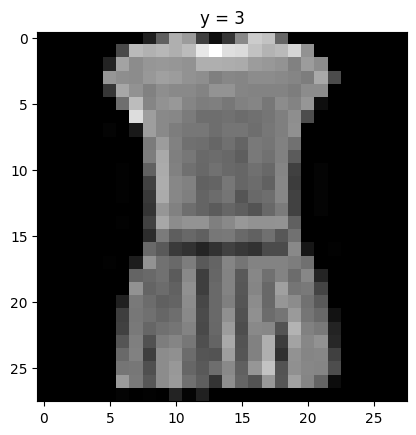

In [ ]:
# The image for the fourth data element
show_data(train_dataset[3])


The fourth sample is a "3".


<!--Empty Space for separating topics-->


<h2 id="CNN">Build a Two Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layer.


In [ ]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. But we add Batch Norm for the convolutional layers.


In [ ]:
class CNN_batch(nn.Module):

    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

Function to train the model


In [ ]:

def train_model(model, train_loader, validation_loader, optimizer, n_epochs):
    train_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    N_test = len(validation_loader.dataset)

    for epoch in range(n_epochs):
        epoch_train_loss = 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x, y
            yhat_train = model(x)
            loss = criterion(yhat_train, y)
            epoch_train_loss += loss
            loss.backward()
            optimizer.step()
        train_loss_list.append((epoch_train_loss/len(train_dataset)).item())

        correct = 0
        with torch.no_grad():
            for x_cv, y_cv in validation_loader:
                model.eval()
                x_cv, y_cv = x_cv, y_cv
                yhat_validation = model(x_cv)
                _, yhat_max = torch.max(yhat_validation, 1)
                correct += (yhat_max == y_cv).sum().item()
            accuracy = correct / N_test
            accuracy_list.append(accuracy)
            print(f'Epoch: {epoch} ------ last loss item: {loss} ------ accuracy: {accuracy}')

    return accuracy_list, train_loss_list ,validation_loss_list



<h2 id="Train">Define the Convolutional Neural Network Classifier, Criterion function, Optimizer and Train the Model</h2>


There are 16 output channels for the first layer, and 32 output channels for the second layer


In [ ]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

Define the loss function, the optimizer and the dataset loader


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

Train the model and determine validation accuracy technically test accuracy **(This may take a long time)**


In [ ]:
# Train the model
accuracy_list_normal, loss_list_normal=train_model(model=model,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

Epoch: 0 ------ last loss item: 0.4204699993133545 ------ accuracy: 0.8391
Epoch: 1 ------ last loss item: 0.3259360194206238 ------ accuracy: 0.8664
Epoch: 2 ------ last loss item: 0.2852664887905121 ------ accuracy: 0.8781
Epoch: 3 ------ last loss item: 0.25899940729141235 ------ accuracy: 0.8855
Epoch: 4 ------ last loss item: 0.24061299860477448 ------ accuracy: 0.8897
Epoch: 5 ------ last loss item: 0.23180663585662842 ------ accuracy: 0.8926
Epoch: 6 ------ last loss item: 0.22296184301376343 ------ accuracy: 0.8953
Epoch: 7 ------ last loss item: 0.21902334690093994 ------ accuracy: 0.8975
Epoch: 8 ------ last loss item: 0.21221962571144104 ------ accuracy: 0.899
Epoch: 9 ------ last loss item: 0.20632430911064148 ------ accuracy: 0.9004


TypeError: ignored

Repeat the Process for the model with  batch norm


In [ ]:
model_batch=CNN_batch(out_1=16, out_2=32)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list, train_loss_list ,validation_loss_list=train_model(model=model_batch,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

Epoch: 0 ------ last loss item: 0.24522706866264343 ------ accuracy: 0.8904
Epoch: 1 ------ last loss item: 2.3015193939208984 ------ accuracy: 0.1
Epoch: 2 ------ last loss item: 1.1374553442001343 ------ accuracy: 0.6454
Epoch: 3 ------ last loss item: 0.4083433449268341 ------ accuracy: 0.8561
Epoch: 4 ------ last loss item: 0.34775906801223755 ------ accuracy: 0.87
Epoch: 5 ------ last loss item: 0.3281010687351227 ------ accuracy: 0.8767
Epoch: 6 ------ last loss item: 0.3073829412460327 ------ accuracy: 0.8783
Epoch: 7 ------ last loss item: 0.29546475410461426 ------ accuracy: 0.88
Epoch: 8 ------ last loss item: 0.2834315001964569 ------ accuracy: 0.8815
Epoch: 9 ------ last loss item: 0.27024608850479126 ------ accuracy: 0.882


<!--Empty Space for separating topics-->


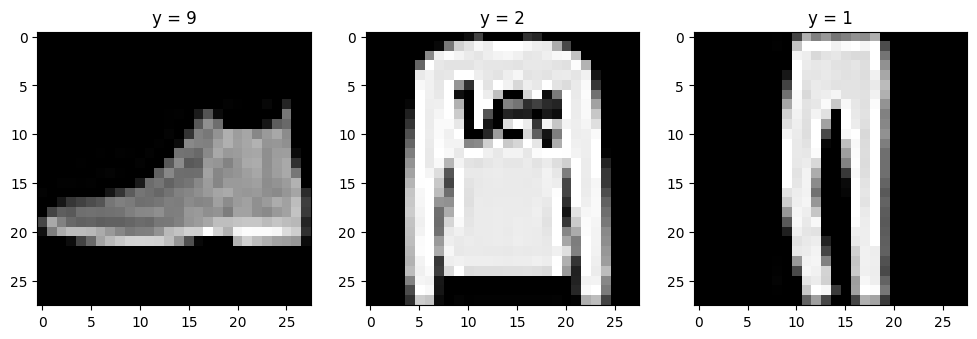

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    plt.sca(axes[i])
    show_data(validation_dataset[i])
plt.show()

<h2 id="Result">Analyze Results</h2>


Plot the loss with both networks.


In [ ]:
def plot_loss_and_accuracy(train_loss_list, accuracy_list):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 1, 1)
    plt.plot(train_loss_list, label="Training Loss", color='tab:blue')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.twinx()
    plt.plot(accuracy_list, label="Validation Accuracy", color='tab:green')
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")
    plt.title("Training Loss and Validation Accuracy")
    plt.show()


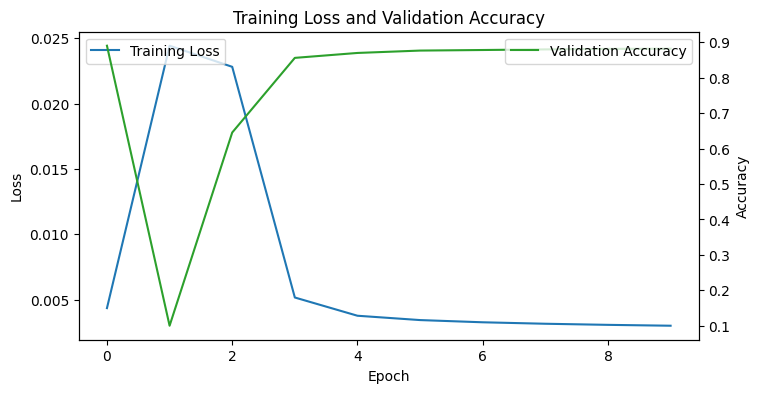

In [ ]:
plot_loss_and_accuracy(  train_loss_list ,accuracy_list)


We see the CNN with batch norm performers better, with faster convergence.


<!--Empty Space for separating topics-->
